In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prerequisites
In order to discuss the internals of optimization methods like `Adam`, $\ldots$<br>
we will first elaborate on the prerequisites:
+ <font color="green"><b>Exponentially Weighted Moving Averages</b></font> (EWMA)
+ <font color="green"><b>Momentum based gradient descent</b></font>
+ <font color="green"><b>Root Mean Square Propagation</b></font> (RMSProp)

## 1.Exponentially Weighted Moving Averages
The technique of moving averages is commonplace in time series analysis (see e.g., Brockwell).
* Let ${x_t}$ be a time series indexed by $t$.
* Let $\beta \in (0,1)$ be a fixed `smoothing factor`.

The `Exponentially Weighted Moving Average` (EWMA) $S_t$ is then given by:
\begin{eqnarray}
    m_t & = & \beta \, m_{t-1} + (1-\beta)\, x_{t}
\end{eqnarray}

Using **recursion**, we can easily derive the following relation for $m_t$:
\begin{eqnarray}
  m_t = \beta^t\, m_0 + (1-\beta) \sum_{j=0}^{t-1} \beta^j \, x_{t-j}
\end{eqnarray}

In [4]:
def ewma(x, beta, mstart=0.0):
    """
    Computes the Exponentially Weighted Moving Average (EWMA) of a sequence.

    Parameters:
        x (array-like): Input sequence of values (e.g., temperatures).
        beta (float): Smoothing factor between 0 and 1. Higher values give more weight to past values.
        mstart (float, optional): Initial value for the EWMA. Default is 0.0.

    Returns:
        numpy.ndarray: Array of the same shape as `temp` containing the EWMA values.
    """ 
    m = np.zeros(x.shape,dtype=np.float64)
    betac = 1.0 - beta
    
    for i in range(len(x)):
        if i==0:
            m[i] = beta*mstart + betac*x[i]
        m[i] = beta*m[i-1] + betac*x[i]
    return m

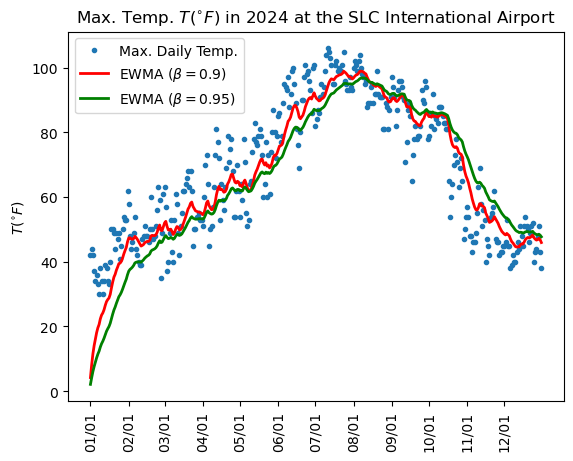

In [99]:
# Read temperatures at Salt Lake City International Airport (01/01/2024 -> 12/31/2024) 
# Source: https://www.ncei.noaa.gov/cdo-web/
df = pd.read_csv("../data/4148860.csv", usecols=['DATE','TMAX'])
first_days = df[pd.to_datetime(df['DATE']).dt.day==1]['DATE']
date_labels = pd.to_datetime(first_days).dt.strftime("%m/%d")

temp = df['TMAX'].to_numpy()
temp_smoothed1 = ewma(temp, beta=0.9)
temp_smoothed2 = ewma(temp, beta=0.95)

fig, ax = plt.subplots()
ax.plot(df['DATE'], df['TMAX'], '.', label="Max. Daily Temp.")
ax.plot(df['DATE'], temp_smoothed1, label=r"EWMA ($\beta=0.9$)", 
        linestyle='-', linewidth=2, color="red")
ax.plot(df['DATE'], temp_smoothed2, label=r"EWMA ($\beta=0.95$)", 
        linestyle="-", linewidth=2, color="green")
ax.set_ylabel(r"$T(^{\circ}F)$")
ax.set_xticks(first_days)
ax.set_xticklabels(date_labels, rotation=90)
ax.legend()
plt.title(r"Max. Temp. $T(^{\circ}F)$ in 2024 at the SLC International Airport") 
plt.show()

### 1.1.Rate of decay 
What value of $j$ do we need for $\beta^j$ to be of the order of $e^{-1}$?
* Given that $ \displaystyle \lim_{z \to 0} \,(1-z)^{-1/z} = e$
* Therefore, for small values of $1 -\beta$, we get:
  \begin{eqnarray}
    (1 -(1-\beta))^{\frac{1}{1-\beta}} & \approx & e^{-1} \\
            \beta^{\frac{1}{1-\beta}} & \approx & e^{-1}
  \end{eqnarray}<br>
  or: $j \approx \frac{1}{1-\beta}$.

### 1.2.Bias Correction 
We previously assumed that $m_0:=0$.<br>
For <font color="green"><b>small</b></font> $t$, $m_t$ is significantly underestimating the true signal.<br>
This can be remediated by a <font color="green"><b>bias correction</b></font>.

For $\beta <1$, we have the following identity:
\begin{eqnarray}
   1 & = &(1-\beta) \sum_{j=0}^{\infty} \beta^j  \\
     & =  &(1-\beta) \sum_{j=0}^{t-1} \beta^j \,+\, (1-\beta) \sum_{j=t}^{\infty} \beta^j \\                                         & = & (1-\beta^t) + (1-\beta) \sum_{j=t}^{\infty} \beta^j \\
\end{eqnarray}

In the previous result, the second term was absent (we ended the recursion at $t=1$). We can remediate for its absence  
by scaling the first term by a factor of $K$.  
\begin{eqnarray}
   1 & = & K \, (1-\beta^t)  
\end{eqnarray}
The scaling factor $K(t;\beta)$ thus becomes $K(t;\beta):=\displaystyle \frac{1}{1 -\beta^t}$.

The scaled/bias corrected version of $m_t$, i.e. $\widehat{m_t}$ is thus:
\begin{eqnarray}
   \widehat{m_t} &:=& K(t;\beta) \, m_t \\
                & = & \frac{m_t}{1-\beta^t}
\end{eqnarray}

From the picture below and the aforementioned equation, we immediately notice:
- the bias' correction **major influence** at the <font color="green"><b>start</b></font> of the ECWA.
- the **almost negligent correction** for <font color="green"><b>larger values</b></font> of $t$, i.e.
  \begin{eqnarray}
      \displaystyle \lim_{t \to \infty} K(t;\beta) = 1
  \end{eqnarray}

In [4]:
# Read temperatures at Salt Lake City International Airport (01/01/2024 -> 12/31/2024) 
# Source: https://www.ncei.noaa.gov/cdo-web/
df = pd.read_csv("../data/4148860.csv", usecols=['DATE','TMAX'])
first_days = df[pd.to_datetime(df['DATE']).dt.day==1]['DATE']
date_labels = pd.to_datetime(first_days).dt.strftime("%m/%d")

temp = df['TMAX'].to_numpy()
BETA = 0.9
temp_smoothed1 = ewma(temp, beta=BETA)
denom = 1.0 - BETA**np.arange(1,temp_smoothed1.shape[0]+1)
temp_smoothed2 = temp_smoothed1/denom

fig, ax = plt.subplots()
ax.plot(df['DATE'], df['TMAX'], '.', label="Max. Daily Temp.")
ax.plot(df['DATE'], temp_smoothed1, label=r"EWMA ($\beta=0.9$)", 
        linestyle='-', linewidth=2, color="red")
ax.plot(df['DATE'], temp_smoothed2, label=r"EWMA ($\beta=0.9$) bias-corrected", 
        linestyle="-", linewidth=2, color="orange")
ax.set_ylabel(r"$T(^{\circ}F)$")
ax.set_xticks(first_days)
ax.set_xticklabels(date_labels, rotation=90)
ax.legend()
plt.title(r"Max. Temp. $T(^{\circ}F)$ in 2024 at the SLC International Airport") 
plt.show()

NameError: name 'ewma' is not defined

## 2.Momentum-based gradient descent

* **Goal**<br>
  To <font color="green"><b>reduce oscillations</b></font> during the gradient descent minimization process<br>
  and thereby <font color="green"><b>accelerate convergence</b></font>.
 
* **Approach**<br>
  Apply <font color="green"><b>Exponentially Weighted Moving Average</b></font> (EWMA) to smooth the gradients.

* **Results**<br>
  + Enables <font color="green"><b>larger steps</b></font> in flat regions of the loss surface.
  + Enables <font color="green"><b>smaller steps</b></font> in highly curved regions, reducing oscillations.
  
* **Mathematical formulation**<br>
  \begin{eqnarray}
    \theta^{[l]}_t & = & \beta \, \theta^{[l]}_{t-1} + (1-\beta)\, dW^{[l]}_{t} \nonumber \\
    \xi^{[l]}_t & = & \beta \, \xi^{[l]}_{t-1} + (1-\beta)\, db^{[l]}_{t} \nonumber \\
  \end{eqnarray}
  where:
  + $l$: layer of the deep neural net ($ l \in \{1,2,\ldots,L\}$)
  + $\theta^{[l]}_t$: EWMA of $dW^{[l]}$
  + $\xi^{[l]}_t$: EWMA of $db^{[l]}_{t}$

  <br>
  The <font color="green"><b>update of the parameters</b></font> then becomes:<br>
  $\texttt{for(l=1,...,L)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      W^{[l]}_t & = & W^{[l]}_t - \alpha \,\theta^{[l]}_t \\
      b^{[l]}_t & = & b^{[l]}_t - \alpha \,\xi^{[l]}_t \\
  \end{eqnarray}$<br>
  $\texttt{done}$

  <br>

* **Remarks**
  + Instead of using $\theta^{[l]}_t$ and $\xi^{[l]}_t$, their <font color="green"><b>bias-corrected</b></font> versions $\widehat{\theta}^{[l]}_t$ and $\widehat{\xi}^{[l]}_t$ can be used:
  \begin{eqnarray}
     \widehat{\theta}^{[l]}_t = & \frac{\theta^{[l]}_t}{1- \beta^t} \\
     \widehat{\xi}^{[l]}_t   = & \frac{\xi^{[l]}_t}{1- \beta^t}
  \end{eqnarray}
  + This correction is mainly relevant during the early stages of optimization, as the number of iterations is typically large.
  + The <font color="green"><b>hyperparameter</b></font> $\beta$ is often set to $0.9$.

* **Physical Analogy**<br>
  Momentum-based gradient descent is inspired by classical mechanics.<br>
  Consider an object subjected to an external force $\mathbf{F}$ in a medium with viscosity $\eta$. Its motion is described by:
  \begin{eqnarray}
       m\frac{d^2 \mathbf{x}}{dt^2} \,+\, K \eta \frac{ d\mathbf{x}}{dt} & = & \mathbf{F}  \\
  \end{eqnarray}
    The factor $K$ is a coefficient dependent on the shape of the object.<br>
    Rearranging this equation yields an expression analogous to momentum-based optimization.
     \begin{eqnarray}
        \mathbf{v} = \frac{1}{K\eta}\mathbf{F} - \frac{1}{K\eta}\frac{d \mathbf{p}}{dt}
     \end{eqnarray}  

## 3.RMSProp

The <font color="green"><b>Root Mean Square Propagation</b></font> (RMSProp) method has identical goals as the momentum-based optimization (i.e. reducing the oscillation in the convergency of the gradient descent). It proceeds mathematically in a slightly different fashion.

* **Mathematical formulation**<br>
  \begin{eqnarray}
    \tau^{[l]}_t & = & \widetilde{\beta} \, \tau^{[l]}_{t-1} + (1-\widetilde{\beta})\, dW^{[l]}_{t} \odot dW^{[l]}_{t} \nonumber \\
    \psi^{[l]}_t & = & \widetilde{\beta} \, \psi^{[l]}_{t-1} + (1- \widetilde{\beta})\, db^{[l]}_{t} \odot  db^{[l]}_{t}\nonumber \\
  \end{eqnarray}
  where:
  + $l$: layer of the deep neural net ($ l \in \{1,2,\ldots,L\}$)
  + $\tau^{[l]}_t$: EWMA of $dW^{[l]}_{t} \odot dW^{[l]}_{t}$ (element-wise square)
  + $\psi^{[l]}_t$: EWMA of $db^{[l]}_{t} \odot db^{[l]}_{t}$ (element-wise square)

  <br>
  The <font color="green"><b>update of the parameters</b></font> then becomes:<br>
  $\texttt{for(l=1,...,L)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      W^{[l]}_t & = & W^{[l]}_t - \alpha \displaystyle \frac{dW^{[l]}_t}{\sqrt{\tau^{[l]}_t + \epsilon }} \\
      b^{[l]}_t & = & b^{[l]}_t - \alpha \displaystyle \frac{db^{[l]}_t}{\sqrt{\psi^{[l]}_t + \epsilon }}
  \end{eqnarray}$<br>
  $\texttt{done}$

  The value of $\epsilon$ is set to very small values (e.g. $10^{-8}$) to prevent division by zero. 

## 4.Adaptive Moment Estimation (Adam)
Adaptive Moment Estimation (Adam) is a combination of:
+ Momentum-based gradient descent
+ RMSProp

This [**algorithm**](https://arxiv.org/pdf/1412.6980) was developed by **Diederik Kingma** and **Jimmy Ba**.  

**Mathematical formulation**

* <font color="green"><b>Momentum-based gradient descent</b></font>
  \begin{eqnarray}
    \theta^{[l]}_t & = & \beta_1 \, \theta^{[l]}_{t-1} + (1-\beta_1)\, dW^{[l]}_{t} \nonumber \\
    \xi^{[l]}_t & = & \beta_1 \, \xi^{[l]}_{t-1} + (1-\beta_1)\, db^{[l]}_{t} \nonumber \\
  \end{eqnarray}
  Further:
  \begin{eqnarray}
     \widehat{\theta}^{[l]}_t = & \frac{\theta^{[l]}_t}{1- \beta_1^t} \\
     \widehat{\xi}^{[l]}_t   = & \frac{\xi^{[l]}_t}{1- \beta_1^t}
  \end{eqnarray}

* <font color="green"><b>RMSProp</b></font>
  
  \begin{eqnarray}
    \tau^{[l]}_t & = & \beta_2 \, \tau^{[l]}_{t-1} + (1- \beta_2)\, dW^{[l]}_{t} \odot dW^{[l]}_{t} \nonumber \\
    \psi^{[l]}_t & = & \beta_2 \, \psi^{[l]}_{t-1} + (1- \beta_2)\, db^{[l]}_{t} \odot  db^{[l]}_{t}\nonumber \\
  \end{eqnarray}
  
  Further:
  \begin{eqnarray}
     \widehat{\tau}^{[l]}_t = & \frac{\tau^{[l]}_t}{1- \beta_2^t} \\
     \widehat{\psi}^{[l]}_t   = & \frac{\psi^{[l]}_t}{1- \beta_2^t}
  \end{eqnarray}
  
 
  The <font color="green"><b>update of the parameters</b></font> then becomes:<br>
  $\texttt{for(l=1,...,L)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      W^{[l]}_t & = & W^{[l]}_t - \alpha \displaystyle \frac{\widehat{\theta}^{[l]}_t}{\sqrt{\widehat{\tau}^{[l]}_t} + \epsilon } \\
      b^{[l]}_t & = & b^{[l]}_t - \alpha \displaystyle \frac{\widehat{\xi}^{[l]}_t}{\sqrt{\widehat{\psi}^{[l]}_t} + \epsilon }
  \end{eqnarray}$<br>
  $\texttt{done}$


The <font color="green"><b>hyperparameters</b></font> are set by a lot of packages to the following values:
\begin{eqnarray}
    \beta_1 & = & 0.9 \\
    \beta_2 & = & 0.999 \\
    \epsilon & = & 10^{-8}
\end{eqnarray}



# Bibliography
* [Peter J. Brockwell and Richard A. Davis, **Time Series: Theory and Methods**](https://www.amazon.com/Time-Methods-Peter-J-Brockwell/dp/0387974296/)

https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf